In [ ]:
from scipy import stats
from matplotlib.pyplot import *
from numpy import *
import fastIsing
import networkx as nx, IO, multiprocessing as mp
from tqdm import tqdm_notebook as tqdm

# dataDir = 'Psycho' # relative path careful
# df    = IO.readCSV('{}/Graph_min1_1.csv'.format(dataDir), header = 0, index_col = 0)
# h     = IO.readCSV('{}/External_min1_1.csv'.format(dataDir), header = 0, index_col = 0)
# graph   = nx.from_pandas_adjacency(df) 
graph = nx.random_graphs.barabasi_albert_graph(30, 10)
# graph = nx.grid_2d_graph(2, 2, periodic = True)
# graph  = nx.path_graph(5, nx.DiGraph())
# graph.add_edge(0, 0)
# graph = nx.path_graph(3)
temp  = 1
model = fastIsing.Ising(graph, temp, True, mode = 'async', verbose = True)
print('made model')
N =  int(1e5)
res = model.simulate(N, verbose = True)
n = res.shape[0]
delta = 1000
cond  = {}
cc    = {}
state = {}

Z   = n - delta 
jdx = 1

for i in tqdm(range(delta, n - jdx)):
    tmp = res[i - delta: i + jdx]
    x =  tuple(res[i])
    state[x] = state.get(x, 0) + 1 / Z
    cond[x] = cond.get(x, zeros(tmp.shape)) +  ((tmp + 1) / 2)
    cc[x] = cc.get(x, 0) + 1
print(f'unique states {len(cond)}')    

H  = zeros((delta + jdx, model.nNodes))
px = zeros((delta + jdx, model.nNodes))

for key, value in tqdm(cond.items()):
    z = value / cc[key]
    assert all(z - 1 - z) == 1
    z[isnan(z)] = 0
    px += value / Z
    x = dstack((z * log2(z), (1 - z) * log2(1 - z)))
    x = nansum(x, -1)
    H += state[key] * x
tmp = nansum(dstack((px * log2(px), (1 - px) * log2(1 - px))), -1)
H  -= tmp



external field not detected assuming 0
Initialized ISING model with 
temperature: 1
mode: async
Equilibrating using N = 10000
Starting burnin


  0%|          | 271/100000 [00:00<00:36, 2708.03it/s]

Number of bunin samples used 10002


absolute mean magnetization last sample 1.0
made model
Simulation parameters
 number of samples: 100000
 step size 1
 pulse : {}


100%|█████████▉| 99926/100000 [00:31<00:00, 3269.66it/s]

100%|██████████| 100000/100000 [00:50<00:00, 3269.66it/s]

In [ ]:
fig, ax = subplots(); ax.plot(H);
fig, ax = subplots(); ax.plot(res.mean(1)) #
fig, ax = subplots()
for node in model.nodeIDs:
    deg = len(model.edgeData[node])
    ax.scatter(deg, H[-2, node])
   
fig, ax = subplots()
ax.hist(list(dict(nx.degree(graph)).values()))
setp(ax, **dict(xlabel = 'degree', ylabel = 'freq'));
fig, ax = subplots(); ax.hist(cc.values())
show()

print(res.dtype)

Text(0.5,1,'hellinger distance over time')

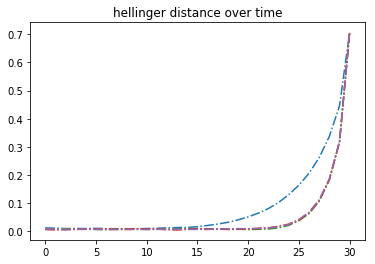

In [12]:
# showing hellinger distance over time
hd = lambda x, y: linalg.norm( sqrt(x) - sqrt (y), axis = -1) / sqrt(2)
d = zeros(H.shape)
for key, value in cond.items():
    x = value[..., None] / cc[key]
    d += hd(x,  1 - x)
d /= len(cond)

fig, ax = subplots(); ax.plot(d, '-.')
ax.set_title('hellinger distance over time')

Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.


/home/casper/miniconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has reached maxfev = 1400.
Optimal parameters not found: Number of calls to function has rea

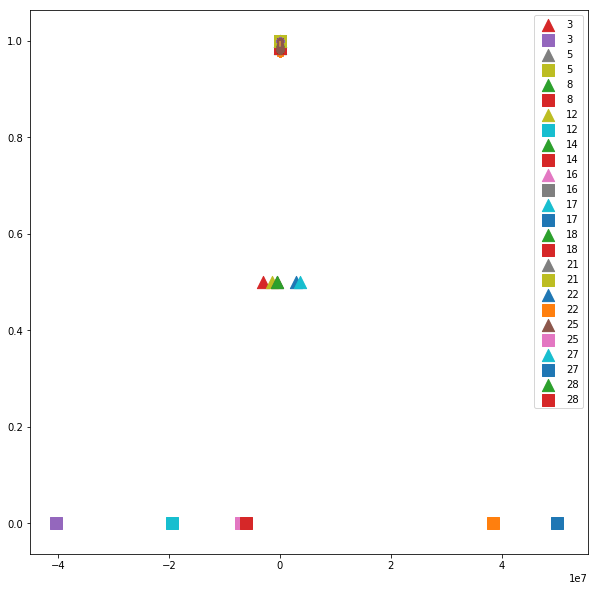

In [25]:
from scipy import optimize
func = lambda x, a, b, c, d, e, f : a * exp(-b * x)   + c * exp(-d * x) #+ e * exp(- f * x)
f2   = lambda x, a, b : func(x, *a) - b
fig, ax = subplots(figsize = (10, 10))
s = 0
idt = zeros((model.nNodes, 2))
for idx, y in enumerate(H.T):
    y = y[::-1]
    x = arange(len(y))
    xx = linspace(0, 100)
    try:
        a, b = optimize.curve_fit(func, x,  y, maxfev = 1400)
        ax.plot(xx, func(xx, *a), '--', alpha = 1)
        tmp = (tuple(a),  .5 * y[0])
        r  = optimize.root(f2,  x0 = 0, args = tmp)
        rr = optimize.root(f2, x0 = 0 , args = (tuple(a), 1e-4))
        idt[idx] = (r.x, rr.x)
        ax.scatter(r.x, func(r.x, *a), s = 150, marker = '^', label = idx)
        ax.scatter(rr.x, func(rr.x, *a), s = 150, marker = 's', label = idx)
        s += 1
    except Exception as e : print(e)
    ax.scatter(x, y, s = 40)
ax.legend()
print(s / model.nNodes * 100)
# ax.set_xlim(-5, 1)
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 1)
# ax.set_xscale('log')
show()

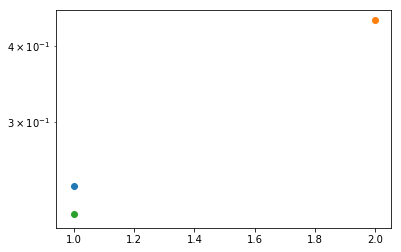

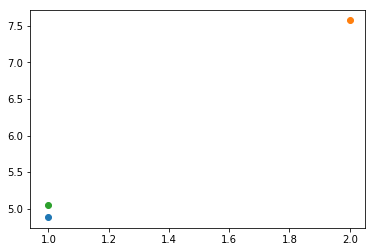

In [5]:
fig, ax = subplots()
fig, axx = subplots()
for node, deg in nx.degree(model.graph):
    idx = model.rmapping[node]
    ax.scatter(deg, idt[idx, 0])
    axx.scatter(deg, idt[idx, 1])
# ax.set_ylim(0, -5)
# axx.set_ylim(0, -5)
ax.set_yscale('log')

